# Project 3 Collaboration and Competition
## Introduction
The goal of this project is to train two competitive agents to play tennis against each other. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. So, our goal is to keep the ball volleying as long as possible. We consider the environment solved when the agents achieve an average score of +0.5 over 100 consecutive episodes.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import copy
import random

from unityagents import UnityEnvironment
from collections import namedtuple, deque
from tqdm import tqdm_notebook
%matplotlib inline

## Set up the environment

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


cuda:0


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Multi Agent Deep Deterministic Policy Gradient Agent
We implement the [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/abs/1509.02971) algorithm for this agent. DDPG is an adaptation of Deep Q-learning to a continuous action space and we can adapt this to our multi-agent environment using techniques introduced by [Lowe et al.](https://arxiv.org/abs/1706.02275) to conduct multi-agent coordination. We could have used D4PG as in our previous project as well.

The actors are neural networks with two hidden layers whose outputs are activated with tanh to produce an output in the range \[-1, 1\]. The critic accepts a (state, action) tuple and outputs the Q value learned for that pair.

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build a network that maps state -> action values"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of neurons in the first hidden layer
            fc2_units (int): Number of neurons in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(2 * (state_size + action_size), fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a network that maps (state, action) -> Q values"""
        x = F.leaky_relu(self.fc1(torch.cat((state, action.float()), dim=1)))
        x = self.bn(x)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [6]:
class ReplayBuffer():
    """Buffer to replay experience tuples"""
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize ReplayBuffer class
        
        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Length of replay buffer
            batch_size (int): Size of each training mini-batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add_experience(self, state, action, reward, next_state, done):
        """Append an experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """Sample experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the length of the memory"""
        return len(self.memory)


class OUNoise:
    """Ornstein-Uhlenbeck noise process to be added to the actions."""

    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [7]:
class MADDPG_Agent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=512, update_every=4, 
                 no_agents=2, alpha=.001, beta=.001, gamma=.99, tau=.008, epsilon=0.99):
        """ Initialize agent attributes
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            buffer_size (int): Size of replay buffer
            batch_size (int): Batch size for replay buffer
            no_agents (int): Number of agents
            alpha (float): Learning rate for actor
            beta (float): Learning rate for critic
            tau (float): Soft update multiplier
            epsilon (float): Parameter for controlling exploration vs exploitation via OU noise
        """
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.no_agents = no_agents
        
        self.local_actor = Actor(state_size, action_size).to(device)
        self.target_actor = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.local_actor.parameters(), lr=alpha)
        
        self.local_critic = Critic(state_size, action_size).to(device)
        self.target_critic = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.local_critic.parameters(), lr=beta)
        
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.noise = OUNoise((no_agents, action_size))
        self.timesteps = 0
        
    def step(self, state, action, reward, next_state, done, agent_no):
        """Save experience in replay buffer, use random sample from buffer to learn
        Params
        ======
            state (ndarray): State of the environment
            action (ndarray): Action chosen by the agent
            reward (ndarray): Reward given by the environment
            next_state (ndarray): Next state of the environment
            done (ndarray): Flag to indicate if the episode is finished after this action
            agent_no (int): Which agent (1 or 2) performs the step
        """
        self.timesteps += 1
        self.memory.add_experience(state, action, reward, next_state, done)
        
        if len(self.memory) >= self.batch_size:
            batch = self.memory.sample()
            self.learn(batch, self.gamma, agent_no)
    
    def act(self, states, add_noise=True):
        """Given a state, choose an action to take
        Params
        ======
            state (ndarray): State of the environment
            score (float): Current score
            add_noise (bool): Flag indicating whether or not to add ou noise to the environment
        """
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.no_agents, self.action_size))
        
        self.local_actor.eval() # Set local network to evaluation mode
        with torch.no_grad():
            for agent_no, state in enumerate(states):
                action = self.local_actor(state).cpu().data.numpy()
                actions[agent_no, :] = action
        self.local_actor.train()
            
        if add_noise:
            actions += self.epsilon * self.noise.sample()
                
        return np.clip(action, -1, 1)
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters
        
        Params
        ======
            local_model (nn.Module): model to copy weights from
            target_model (nn.Module): model to copy weights to
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
    
    def learn(self, batch, gamma, agent_no):
        """ Given a batch of experiences, update the local network and soft update on target networks.
        Q = r + gamma * critic_target(next_state, actor_target(next_state))
        
        Params
        ======
            batch (tuple of tensors): Experiences - (states, actions, rewards, next_states, dones)
            gamma (float): Discount factor for rewards
            agent_no (int): Which agent to update
        """
        states, actions, rewards, next_states, dones = batch
        
        next_actions = self.target_actor(next_states)
        
        if agent_no == 0:
            next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
        else:
            next_actions = torch.cat((actions[:,:2], next_actions), dim=1)

        # Compute critic loss
        Q_expected = self.local_critic(states, actions)
        Q_target_next = self.target_critic(next_states, next_actions)
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        critic_loss = F.mse_loss(Q_expected, Q_target)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_critic.parameters(), 1)
        self.critic_optimizer.step()
        
        # Compute actor loss
        actions_pred = self.local_actor(states)
        if agent_no == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        
        actor_loss = -self.local_critic(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Reduce exploration
        # self.epsilon *= self.epsilon
        
        # Soft update
        if self.timesteps % self.update_every == 0:
            self.soft_update(self.local_critic, self.target_critic)
            self.soft_update(self.local_actor, self.target_actor)
        
    def reset(self):
        self.epsilon *= self.epsilon
        self.noise.reset()

## Train agent

In [8]:
agent0 = MADDPG_Agent(state_size, action_size)
agent1 = MADDPG_Agent(state_size, action_size)

In [9]:
n_episodes = 4000
current_score = 0
scores = list()
rolling_average = list()
score_deque = deque(maxlen=100)

for ep in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    states = np.reshape(env_info.vector_observations, (1,48))
    agent0.reset()
    agent1.reset()
    episode_scores = np.zeros(len(env_info.agents))
    while True:
        action_0 = agent0.act(states)
        action_1 = agent1.act(states)
        actions = np.concatenate((action_0, action_1), axis=0).flatten()
        
        env_info = env.step(actions)[brain_name]
        
        next_states = np.reshape(env_info.vector_observations, (1, 48))
        rewards = env_info.rewards
        dones = env_info.local_done
        episode_scores += np.max(rewards)
        
        agent0.step(states, actions, rewards[0], next_states, dones[0], 0)
        agent1.step(states, actions, rewards[1], next_states, dones[1], 1)

        states = next_states
        
        if np.any(dones):
            break
            
    episode_score = np.max(episode_scores)
    score_deque.append(episode_score)
    scores.append(episode_score)
    ra_current = np.mean(score_deque)
    rolling_average.append(ra_current)
    if ep == 1 or ep % 100 == 0:
        print("Episode {} complete! Average score: {:.4f}\tEpisode score: {:.4f}".format(ep, ra_current, episode_score))
    
    if ra_current >= 0.5 and len(score_deque) > 99:
        print("Target reward achieved in {} episodes! Average score: {:.4f}".format(ep, ra_current))
        torch.save(agent0.target_actor.state_dict(), 'agent0_actor_solution.pth')
        torch.save(agent0.target_critic.state_dict(), 'agent0_critic_solution.pth')
        torch.save(agent1.target_actor.state_dict(), 'agent1_actor_solution.pth')
        torch.save(agent1.target_critic.state_dict(), 'agent1_critic_solution.pth')
        break

Episode 1 complete! Average score: 0.0000	Episode score: 0.0000
Episode 100 complete! Average score: 0.0050	Episode score: 0.0000
Episode 200 complete! Average score: 0.0140	Episode score: 0.0000
Episode 300 complete! Average score: 0.0240	Episode score: 0.1000
Episode 400 complete! Average score: 0.0330	Episode score: 0.1000
Episode 500 complete! Average score: 0.0500	Episode score: 0.0000
Episode 600 complete! Average score: 0.0450	Episode score: 0.0000
Episode 700 complete! Average score: 0.1070	Episode score: 0.0000
Episode 800 complete! Average score: 0.1140	Episode score: 0.2000
Episode 900 complete! Average score: 0.1310	Episode score: 0.2000
Episode 1000 complete! Average score: 0.1240	Episode score: 0.1000
Episode 1100 complete! Average score: 0.1080	Episode score: 0.0000
Episode 1200 complete! Average score: 0.1440	Episode score: 0.1000
Episode 1300 complete! Average score: 0.1670	Episode score: 0.3000
Episode 1400 complete! Average score: 0.1850	Episode score: 0.2000
Episode

## Plot Rewards

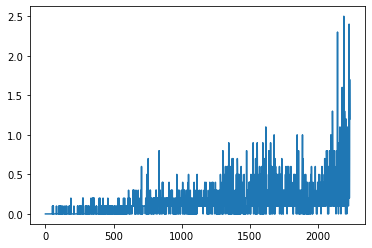

In [10]:
plt.plot(scores)

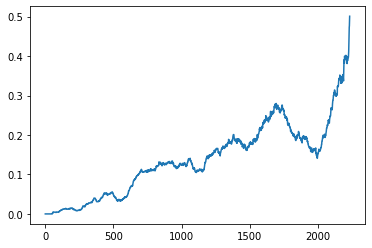

In [12]:
plt.plot(rolling_average)

## Future Improvement
The stability of the algorithm is still questionable - using something like [A3C](https://arxiv.org/pdf/1602.01783.pdf) instead may stabilize training.
Additionally, since so many training epochs feature zero reward, implementing [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) may speed up training by prioritizing epochs with nonzero reward.